In [156]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision import datasets 

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [157]:
image_size = 28
transform=transforms.Compose(
    [
        transforms.Grayscale(),
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

train_set = datasets.ImageFolder("organized_dataset/train", transform=transform)
test_set = datasets.ImageFolder("organized_dataset/test", transform=transform)

train_loader = DataLoader(train_set, batch_size=1028, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1028)

In [158]:
class Encoder(nn.Module):
    def __init__(self, pretrained=True, out_dim=128):
        super(Encoder, self).__init__()
        base_model = resnet18(pretrained=pretrained)

        # Modify first conv layer to accept 1-channel input instead of 3
        original_conv1 = base_model.conv1
        base_model.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=original_conv1.out_channels,
            kernel_size=original_conv1.kernel_size,
            stride=original_conv1.stride,
            padding=original_conv1.padding,
            bias=original_conv1.bias is not None
        )

        # Optional: initialize weights of new conv1
        if pretrained:
            with torch.no_grad():
                # Copy weights from RGB to 1-channel (average over input channels)
                base_model.conv1.weight = nn.Parameter(
                    base_model.conv1.weight.mean(dim=1, keepdim=True)
                )

        self.features = nn.Sequential(*list(base_model.children())[:-1])  # up to avgpool
        self.flatten = nn.Flatten()
        self.projection = nn.Linear(512, out_dim)

    def forward(self, x):
        x = self.features(x)      # (B, 512, 1, 1)
        x = self.flatten(x)       # (B, 512)
        x = self.projection(x)    # (B, 128)
        return x

In [159]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images, support_labels, query_images):
        z_support = self.backbone(support_images)  # (N_support, 128)
        z_query = self.backbone(query_images)      # (N_query, 128)

        unique_labels = torch.unique(support_labels)
        z_proto = torch.stack([
            z_support[support_labels == c].mean(dim=0)
            for c in unique_labels
        ])  # (n_way, 128)

        dists = torch.cdist(z_query, z_proto)  # (n_query, n_way)
        return -dists


# Initialize encoder and load weights
encoder = Encoder(pretrained=False, out_dim=128)
checkpoint = torch.load("best_model.pth", map_location="cuda" if torch.cuda.is_available() else "cpu")
encoder.load_state_dict(checkpoint)
encoder.eval()

# Wrap in Prototypical Networks
model = PrototypicalNetworks(encoder).cuda()


C:\Users\ACER\AppData\Local\Temp\ipykernel_10916\2750887531.py:22: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [160]:
# Parameters
N_WAY = 5
N_SHOT = 5
N_QUERY = 5
N_EVALUATION_TASKS = 100

# Properly assign get_labels as a method (not the result)
def get_labels(self):
    return [label for _, label in self.samples]

# Assign the method to the instance
test_set.get_labels = get_labels.__get__(test_set)

# Create sampler and loader
test_sampler = TaskSampler(
    test_set,
    n_way=N_WAY,
    n_shot=N_SHOT,
    n_query=N_QUERY,
    n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    collate_fn=test_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.6156863].


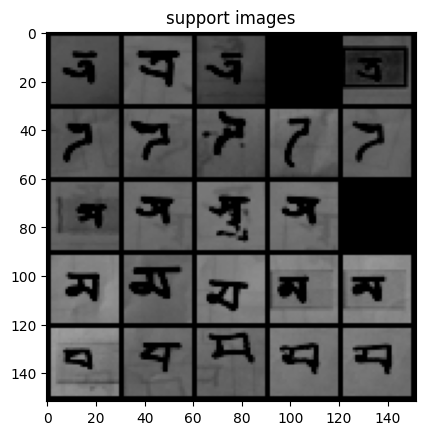

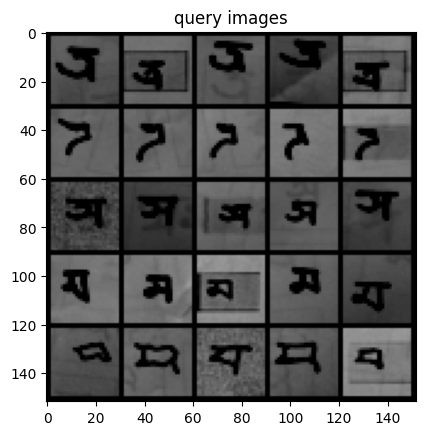

In [161]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=N_SHOT)
plot_images(example_query_images, "query images", images_per_row=N_QUERY)


In [162]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Ground Truth / Predicted")
for i in range(len(example_query_labels)):
    # Get the true and predicted class indices
    true_class_idx = example_class_ids[example_query_labels[i]]
    pred_class_idx = example_class_ids[example_predicted_labels[i]]
    
    # Get the actual class names from the dataset
    true_class = test_set.classes[true_class_idx]
    pred_class = test_set.classes[pred_class_idx]
    
    print(f"{true_class} / {pred_class}")

Ground Truth / Predicted
maithili_tra / tibetan-da
maithili_tra / maithili_saaa
maithili_tra / maithili_tra
maithili_tra / maithili_tra
maithili_tra / maithili_saaa
tibetan-da / tibetan-da
tibetan-da / tibetan-da
tibetan-da / tibetan-ba
tibetan-da / maithili_ma
tibetan-da / tibetan-da
maithili_saaa / maithili_tra
maithili_saaa / maithili_saaa
maithili_saaa / maithili_saaa
maithili_saaa / maithili_saaa
maithili_saaa / maithili_saaa
maithili_ma / maithili_ma
maithili_ma / tibetan-ba
maithili_ma / tibetan-ba
maithili_ma / maithili_saaa
maithili_ma / maithili_tra
tibetan-ba / maithili_saaa
tibetan-ba / maithili_saaa
tibetan-ba / maithili_saaa
tibetan-ba / maithili_tra
tibetan-ba / tibetan-ba


In [163]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0

    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct

    print(
        f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%"
    )


evaluate(test_loader)


100%|██████████| 100/100 [00:08<00:00, 12.23it/s]

Model tested on 100 tasks. Accuracy: 48.84%


In [164]:
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

# Assign the method to the instance
train_set.get_labels = get_labels.__get__(train_set)

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    collate_fn=train_sampler.episodic_collate_fn,
)


In [165]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()


In [166]:
# Train the model yourself with this cell

log_update_frequency = 10

all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)

        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))


100%|██████████| 40000/40000 [43:49<00:00, 15.21it/s, loss=0.0261]  


Now let's see if our model got better!

In [167]:
evaluate(test_loader)


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]

Model tested on 100 tasks. Accuracy: 88.60%


In [168]:
# Save the model's state_dict to a file
torch.save(model.state_dict(), "prototypical.pth")

In [169]:
# Load the saved model weights for inference
inference_encoder = Encoder(pretrained=False, out_dim=128)
inference_model = PrototypicalNetworks(inference_encoder)
inference_model.load_state_dict(torch.load("prototypical.pth", map_location="cuda" if torch.cuda.is_available() else "cpu"))
inference_model.eval()
if torch.cuda.is_available():
    inference_model = inference_model.cuda()

# Example inference on a single episode (support_images, support_labels, query_images)
with torch.no_grad():
    scores = inference_model(
        support_images.cuda() if torch.cuda.is_available() else support_images,
        support_labels.cuda() if torch.cuda.is_available() else support_labels,
        query_images.cuda() if torch.cuda.is_available() else query_images,
    )
    _, predicted_labels = torch.max(scores.data, 1)

print("Predicted labels:", predicted_labels.cpu().numpy())

C:\Users\ACER\AppData\Local\Temp\ipykernel_10916\3863789584.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Predicted labels: [1 1 1 1 1 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 0 0 0 0 0]


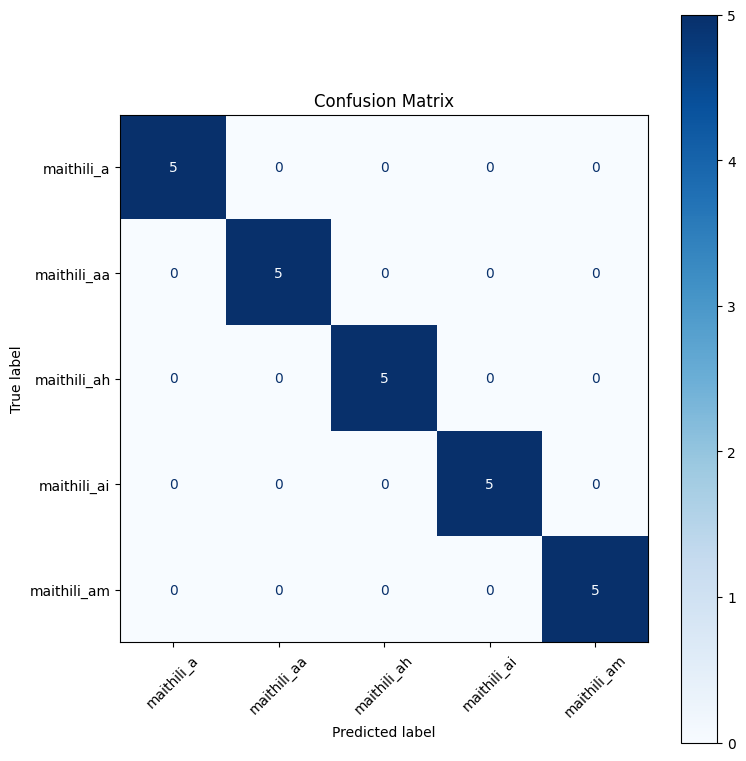

In [170]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# Get true and predicted labels as numpy arrays
y_true = query_labels.cpu().numpy()
y_pred = predicted_labels.cpu().numpy()

# Get the unique class indices for this episode (should be 5 for 5-way classification)
unique_class_indices = np.unique(np.concatenate([y_true, y_pred]))

# If test_set.classes is available, use class names for these indices, else use indices as strings
if hasattr(test_set, "classes"):
    class_labels = [test_set.classes[i] for i in unique_class_indices]
else:
    class_labels = unique_class_indices.astype(str)

# Compute confusion matrix (labels restricts the order to unique_class_indices)
cm = confusion_matrix(y_true, y_pred, labels=unique_class_indices)

# Display confusion matrix
fig_cm, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=True)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [171]:
from sklearn.manifold import TSNE
import pandas as pd

import plotly.express as px

# Get embeddings for support and query images
with torch.no_grad():
    support_embeddings = model.backbone(support_images.cuda()).cpu().numpy()
    query_embeddings = model.backbone(query_images.cuda()).cpu().numpy()

# Concatenate embeddings and labels
all_embeddings = np.concatenate([support_embeddings, query_embeddings], axis=0)
all_labels = np.concatenate([support_labels.cpu().numpy(), query_labels.cpu().numpy()])
all_set_type = np.array(['support'] * len(support_labels) + ['query'] * len(query_labels))

# Run t-SNE in 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=5)
embeddings_3d = tsne.fit_transform(all_embeddings)

# Prepare DataFrame for Plotly
df_tsne = pd.DataFrame({
    'x': embeddings_3d[:, 0],
    'y': embeddings_3d[:, 1],
    'z': embeddings_3d[:, 2],
    'label': all_labels,
    'set': all_set_type
})

fig = px.scatter_3d(
    df_tsne, x='x', y='y', z='z',
    color='label',
    symbol='set',
    title='t-SNE 3D of Support and Query Embeddings',
    labels={'label': 'Class', 'set': 'Set Type'}
)
fig.show()

In [181]:
# Create val_set and val_loader
val_set = datasets.ImageFolder("val", transform=transform)

# Assign get_labels method to val_set
val_set.get_labels = get_labels.__get__(val_set)

val_sampler = TaskSampler(
    val_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_VALIDATION_TASKS
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    collate_fn=val_sampler.episodic_collate_fn,
)

# Evaluate on val set
evaluate(val_loader)

100%|██████████| 100/100 [00:25<00:00,  3.94it/s]

Model tested on 100 tasks. Accuracy: 96.28%
